## Configuration

#### Package Imports

In [24]:
from google.cloud import storage
import copy
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.patches import Rectangle
import matplotlib.patches as patches
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization, GlobalAvgPool2D, concatenate
from tensorflow.keras.layers import Add, ZeroPadding2D, AveragePooling2D, GaussianNoise, SeparableConv2D, Concatenate, LeakyReLU, Reshape, Lambda, Permute
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.layers import add
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
from tensorflow.keras.applications.vgg16 import VGG16
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from skimage.transform import resize
import tensorflow as tf
import tqdm
import numpy as np
import pickle
from PIL import Image
import os
import random
from io import BytesIO
import io
import cv2

#### Script Imports

In [2]:
from src import config_data_processing as cdp
from src import image_manipulation as imm
from src import misc_functions as mf
from src import modeling as m
from src import loss_functions as lf

2021-03-23 15:40:43: Folder path C:/keras_model_save/ already exists
2021-03-23 15:40:43: Folder path C:/keras_epoch_results/ already exists


#### OS Paths

In [29]:
my_project_folder = 'D:/indoor_object_detection/'
airplane_image_path = f'{my_project_folder}RCNN_Data/Images - Copy/'
annot_path = f'{my_project_folder}RCNN_Data/Airplanes_Annotations - Copy/'
model_save_dir = 'D:/iod_model_save/'

## Define Functions

In [19]:
def get_iou(bb1, bb2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters
    ----------
    bb1 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner
    bb2 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x, y) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner

    Returns
    -------
    float
        in [0, 1]
    """
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']
    # determine the coordinates of the intersection rectangle
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])


    if x_right < x_left or y_bottom < y_top:
        return 0.0
    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    # compute the area of both AABBs
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])
    
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

class MyLabelBinarizer(LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1-Y))
        else:
            return Y
    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)

## Data Processing

#### Test File Reading

42845.jpg


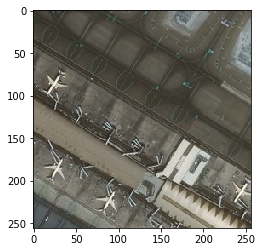

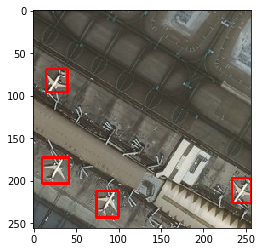

In [4]:
for e,i in enumerate(os.listdir(annot_path)):
    if e < 10:
        filename = i.split(".")[0]+".jpg"
        print(filename)
        img = cv2.imread(f'{airplane_image_path}{filename}')
        df = pd.read_csv(os.path.join(annot_path,i))
        plt.imshow(img)
        for row in df.iterrows():
            x1 = int(row[1][0].split(" ")[0])
            y1 = int(row[1][0].split(" ")[1])
            x2 = int(row[1][0].split(" ")[2])
            y2 = int(row[1][0].split(" ")[3])
            cv2.rectangle(img,(x1,y1),(x2,y2),(255,0,0), 2)
        plt.figure()
        plt.imshow(img)
        break

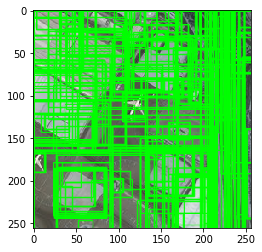

In [7]:
# create Selective Search Segmentation Object using default parameter. 
cv2.setUseOptimized(True);
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()


im = cv2.imread(os.path.join(airplane_image_path,"42850.jpg"))
# set input image on which we will run segmentation.
ss.setBaseImage(im)
# Switch to fast but low recall Selective Search method.
ss.switchToSelectiveSearchFast()
rects = ss.process() # run selective search segmentation on input image.
imOut = im.copy() #create copy of original image
#iterate over all region proposals 
for i, rect in (enumerate(rects)):
    x, y, w, h = rect #draw rectangles for region proposal
#     print(x,y,w,h)  0 0 167 113
#     imOut = imOut[x:x+w,y:y+h]
    cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
# plt.figure()
plt.imshow(imOut)

In [10]:
train_images=[]
train_labels=[]

ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

for e,i in enumerate(os.listdir(annot_path)):
    try:
        if i.startswith("airplane"):
            filename = i.split(".")[0]+".jpg"
            print(e,filename)
            image = cv2.imread(os.path.join(airplane_image_path,filename))
            df = pd.read_csv(os.path.join(annot_path,i))
            gtvalues=[]
            for row in df.iterrows():
                x1 = int(row[1][0].split(" ")[0])
                y1 = int(row[1][0].split(" ")[1])
                x2 = int(row[1][0].split(" ")[2])
                y2 = int(row[1][0].split(" ")[3])
                gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
            ss.setBaseImage(image)
            ss.switchToSelectiveSearchFast()
            ssresults = ss.process()
            imout = image.copy()
            counter = 0
            falsecounter = 0
            flag = 0
            fflag = 0
            bflag = 0
            for e,result in enumerate(ssresults):
                if e < 2000 and flag == 0:
                    for gtval in gtvalues:
                        x,y,w,h = result
                        iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                        if counter < 30:
                            if iou > 0.70:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(1)
                                counter += 1
                        else :
                            fflag =1
                        if falsecounter <30:
                            if iou < 0.3:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(0)
                                falsecounter += 1
                        else :
                            bflag = 1
                    if fflag == 1 and bflag == 1:
                        print("inside")
                        flag = 1
    except Exception as e:
        print(e)
        print("error in "+filename)
        continue

17 airplane_001.jpg
inside
18 airplane_002.jpg
19 airplane_003.jpg
20 airplane_004.jpg
inside
21 airplane_005.jpg
inside
22 airplane_006.jpg
23 airplane_007.jpg
inside
24 airplane_008.jpg
25 airplane_009.jpg
26 airplane_010.jpg
27 airplane_011.jpg
28 airplane_012.jpg
inside
29 airplane_013.jpg
30 airplane_014.jpg
31 airplane_015.jpg
32 airplane_016.jpg
33 airplane_017.jpg
34 airplane_018.jpg
35 airplane_019.jpg
36 airplane_020.jpg
37 airplane_021.jpg
38 airplane_022.jpg
39 airplane_023.jpg
40 airplane_024.jpg
41 airplane_025.jpg
42 airplane_026.jpg
43 airplane_027.jpg
44 airplane_028.jpg
45 airplane_029.jpg
46 airplane_030.jpg
47 airplane_031.jpg
48 airplane_032.jpg
49 airplane_033.jpg
50 airplane_034.jpg
51 airplane_035.jpg
52 airplane_036.jpg
53 airplane_037.jpg
54 airplane_038.jpg
55 airplane_039.jpg
56 airplane_040.jpg
57 airplane_041.jpg
inside
58 airplane_042.jpg
59 airplane_043.jpg
60 airplane_044.jpg
61 airplane_045.jpg
inside
62 airplane_046.jpg
63 airplane_047.jpg
64 airplane

395 airplane_379.jpg
396 airplane_380.jpg
397 airplane_381.jpg
398 airplane_382.jpg
inside
399 airplane_383.jpg
inside
400 airplane_384.jpg
401 airplane_385.jpg
inside
402 airplane_386.jpg
403 airplane_387.jpg
404 airplane_388.jpg
inside
405 airplane_389.jpg
406 airplane_390.jpg
407 airplane_391.jpg
408 airplane_392.jpg
409 airplane_393.jpg
410 airplane_394.jpg
411 airplane_395.jpg
412 airplane_396.jpg
413 airplane_397.jpg
414 airplane_398.jpg
415 airplane_399.jpg
416 airplane_400.jpg


#### Convert Dataset to Numpy

In [13]:
X_new = np.array(train_images)
y_new = np.array(train_labels)

#### Use Imagenet Weights

In [15]:
vggmodel = VGG16(weights='imagenet', include_top=True)
vggmodel.summary()

553467904/553467096 [==============================] - ETA:  - ETA: 1: - ETA: 16s - ETA: 12 - ETA: 10 - ETA: 8 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 5s 0us/step
Model: "vgg16"
_________________________________________________________________
La

In [16]:
for layers in (vggmodel.layers)[:15]:
    print(layers)
    layers.trainable = False

X= vggmodel.layers[-2].output

predictions = Dense(2, activation="softmax")(X)

model_final = Model(vggmodel.input, predictions)

#### Compile Keras Model

In [17]:
opt = Adam(lr=0.0001)
model_final.compile(loss = keras.losses.categorical_crossentropy, optimizer = opt, metrics=["accuracy"])
model_final.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [20]:
        
lenc = MyLabelBinarizer()
Y =  lenc.fit_transform(y_new)

X_train, X_test , y_train, y_test = train_test_split(X_new,Y,test_size=0.10)

print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)
 
# NEW (15872, 224, 224, 3) (1764, 224, 224, 3) (15872, 2) (1764, 2)

###Create train and test datasets.
trdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
traindata = trdata.flow(x=X_train, y=y_train)
tsdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
testdata = tsdata.flow(x=X_test, y=y_test)

(15872, 224, 224, 3) (1764, 224, 224, 3) (15872, 2) (1764, 2)


In [25]:
checkpoint = ModelCheckpoint(f"{model_save_dir}ieeercnn_vgg16_1.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')

hist = model_final.fit_generator(generator= traindata, steps_per_epoch= 10, epochs= 2,
                                 validation_data= testdata, validation_steps=2, callbacks=[checkpoint,early])

W0323 15:53:58.519358 11144 callbacks.py:1184] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of batches seen.
W0323 15:53:58.520862 11144 deprecation.py:323] From <ipython-input-25-906c278ad59b>:5: Model.fit_generator (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
Please use Model.fit, which supports generators.


Epoch 1/2
10/10 [==============================] - ETA: 0s - loss: 1.2601 - accuracy: 0.59 - ETA: 0s - loss: 1.5931 - accuracy: 0.67 - ETA: 0s - loss: 1.2979 - accuracy: 0.72 - ETA: 0s - loss: 1.3851 - accuracy: 0.71 - ETA: 0s - loss: 1.2784 - accuracy: 0.74 - ETA: 0s - loss: 1.3617 - accuracy: 0.71 - ETA: 0s - loss: 1.2202 - accuracy: 0.73 - ETA: 0s - loss: 1.1600 - accuracy: 0.72 - ETA: 0s - loss: 1.1151 - accuracy: 0.70 - ETA: 0s - loss: 1.0723 - accuracy: 0.6969
Epoch 00001: val_loss improved from inf to 0.32633, saving model to ieeercnn_vgg16_1.h5
10/10 [==============================] - 7s 743ms/step - loss: 1.0723 - accuracy: 0.6969 - val_loss: 0.3263 - val_accuracy: 0.8281
Epoch 2/2
10/10 [==============================] - ETA: 0s - loss: 0.2086 - accuracy: 0.90 - ETA: 0s - loss: 0.5608 - accuracy: 0.84 - ETA: 1s - loss: 0.5552 - accuracy: 0.83 - ETA: 0s - loss: 0.5134 - accuracy: 0.84 - ETA: 0s - loss: 0.4366 - accuracy: 0.86 - ETA: 0s - loss: 0.4026 - accuracy: 0.87 - ETA: 0s

## Results / EDA

#### Training Progress

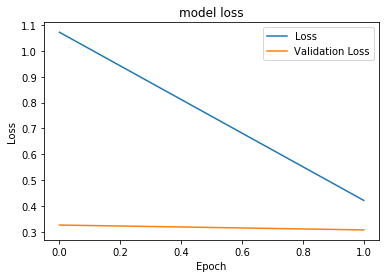

In [26]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()
#plt.savefig('chart loss.png')

#### Test Set Predictions

not plane


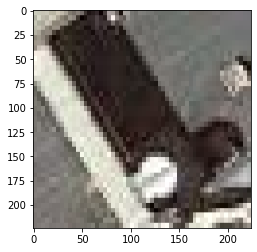

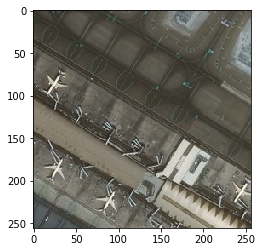

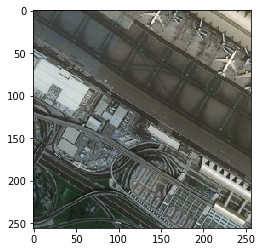

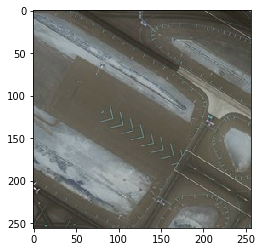

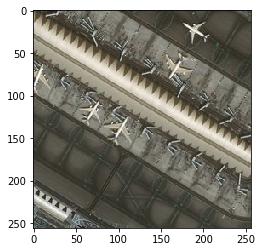

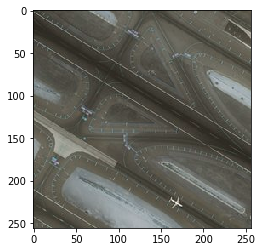

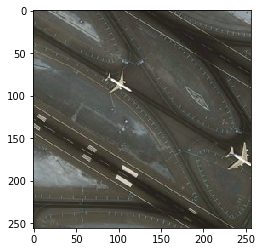

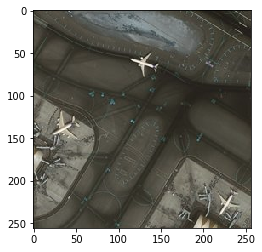

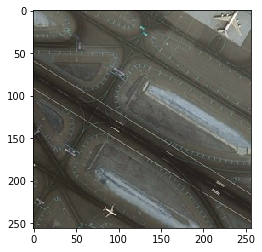

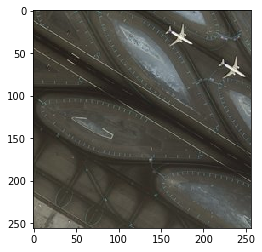

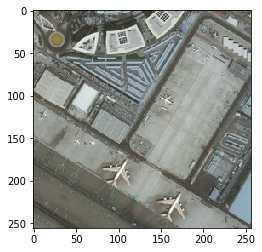

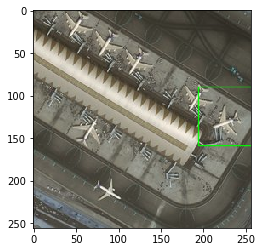

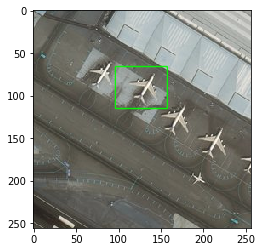

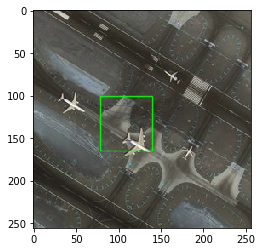

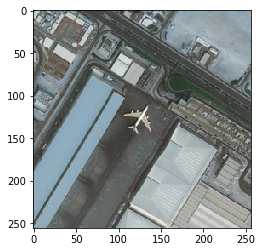

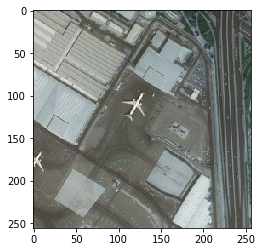

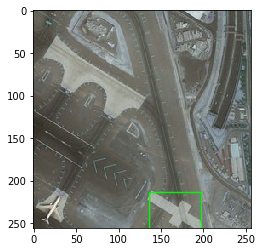

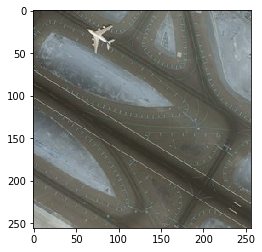

In [28]:
im = X_test[1600]
plt.imshow(im)
img = np.expand_dims(im, axis=0)
out= model_final.predict(img)
if out[0][0] > out[0][1]:
    print("plane")
else:
    print("not plane")

z=0
for e,i in enumerate(os.listdir(airplane_image_path)):
    if i.startswith("4"):
        z += 1
        img = cv2.imread(os.path.join(airplane_image_path,i))
        ss.setBaseImage(img)
        ss.switchToSelectiveSearchFast()
        ssresults = ss.process()
        imout = img.copy()
        for e,result in enumerate(ssresults):
            if e < 2000:
                x,y,w,h = result
                timage = imout[y:y+h,x:x+w]
                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                img = np.expand_dims(resized, axis=0)
                out= model_final.predict(img)
                if out[0][0] > 0.65:
                    cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
        plt.figure()
        plt.imshow(imout)
